# Embedding investigation

Finer investigation on the cluster found in the embedding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns

In [2]:
sys.path.append('../../')
from src import myTools, plotTools

## Data

In [3]:
# --- SOAP data
X = np.load('../1.dscr_analysis/1.soap_data/soap_rcut4_n8_l4/soap_rcut4.5_n_Z1_Z3_Nframe1000every5.npy')

In [6]:
# --- embedded data
Xemb = np.load('./dimred_data/umapSOAPdist_rcut4.5_n_Z1_Z3_Nframe1000every5.npy')
Xlpca = np.load('./dimred_data/lpca_rcut4.5_n_Z1_Z3_Nframe1000every5.npy')[:,:3]
varlpca = np.loadtxt('./dimred_data/lpca_variace_4.5soap.dat')

In [7]:
# -- cluster labels
labels = np.loadtxt('../3.clustering/hdbscan_umapSOAPdist_soapRcut45_finer.labels').astype(int)

In [8]:
# fig, ax = plotTools.get_axes(2,2)

# ax[0].scatter(*Xemb.T, c=labels, s=1, cmap='viridis')
# ax[1].scatter(*Xlpca.T, c=labels, s=1, cmap='viridis')

In [9]:
# sns.color_palette('viridis', 6)

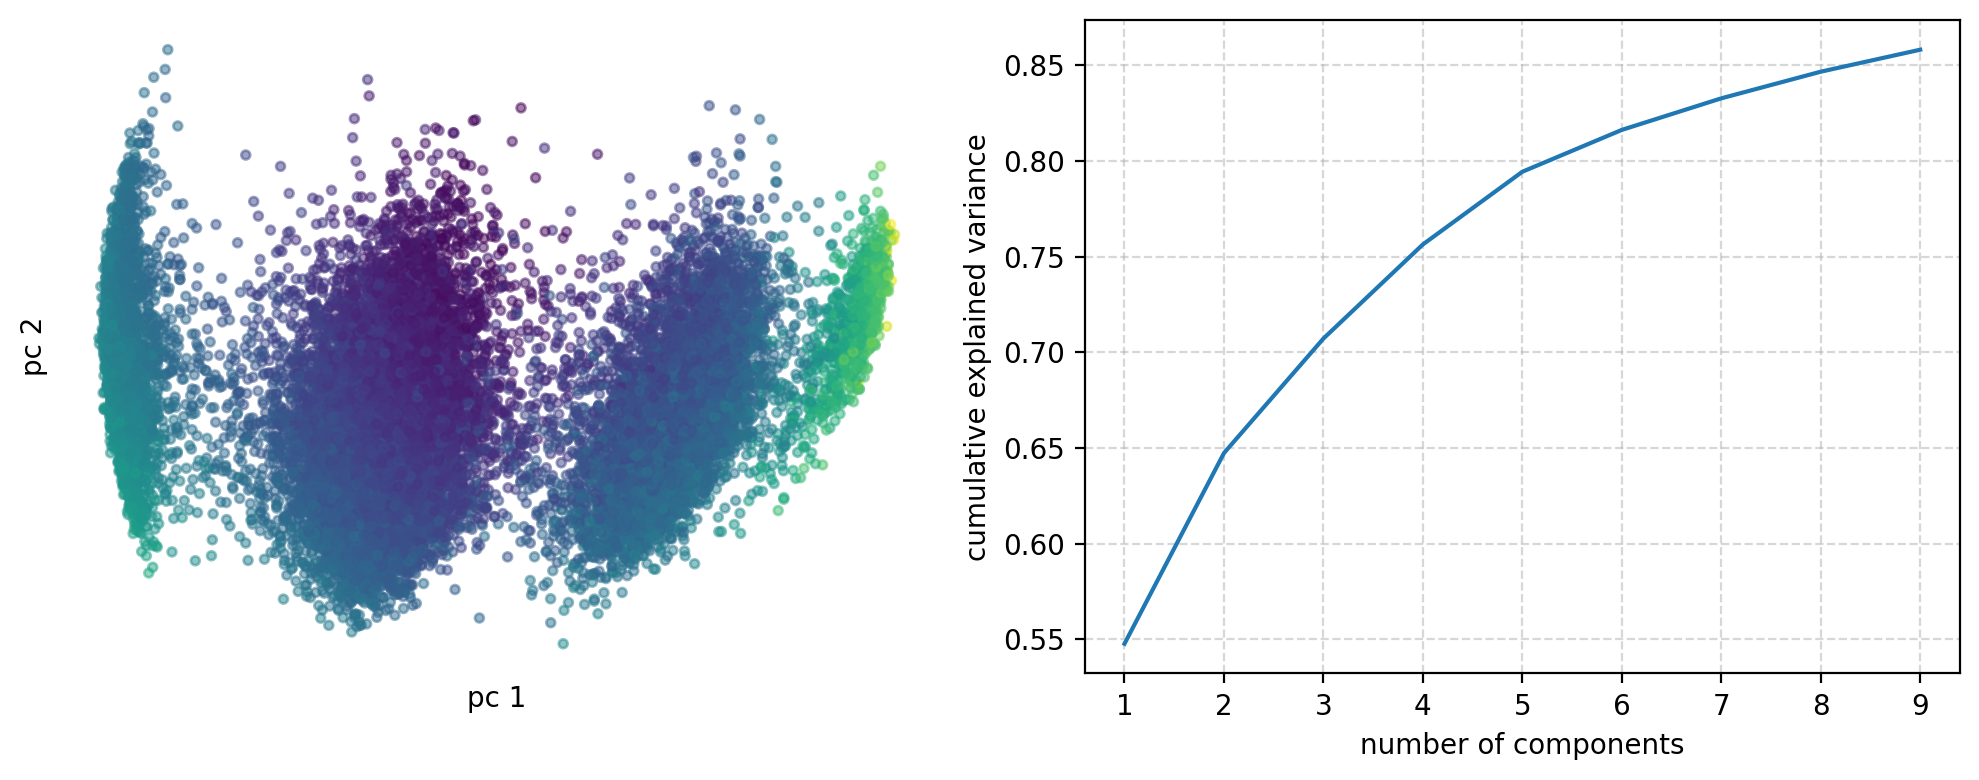

In [21]:
fig, ax = plotTools.get_axes(2,2)

ax[0].scatter(Xlpca[:,0], Xlpca[:,1], 
              c=Xlpca[:,2], s=10, alpha=.5)
ax[0].set_xlabel('pc 1')
ax[0].set_ylabel('pc 2')
plotTools.remove_frame(ax[0])
ax[1].plot(np.arange(1,len(varlpca)+1), varlpca)
ax[1].set_xlabel('number of components')
ax[1].set_ylabel('cumulative explained variance')
ax[1].set_xticks(np.arange(1,10,1))
plt.grid(True, ls='--', alpha=.5)
fig.tight_layout()
fig.savefig("lpca_projection")

## Cluster-wise sampled data

In [8]:
def get_cluster_soap(soapdata, labels):
    cluster_soap = dict()
    
    if len(soapdata.shape) > 2:
        soapdata = np.concatenate(soapdata)

    for cl in np.unique(labels):
        idx_list = list()
        mask = labels == cl
        for idx,cc in enumerate(labels):
            if cc == cl:
                idx_list.append(idx)
        cluster_soap[cl] = (soapdata[mask], idx_list)
    
    return cluster_soap

In [9]:
cluster_soap = get_cluster_soap(soapdata=X, 
                                labels=labels)

In [10]:
cluster_soap.keys()

dict_keys([0, 1, 2, 3, 4, 5])

## re-Fit embeddings

In [11]:
from sklearn.decomposition import PCA, KernelPCA
from umap import UMAP
import numba

In [12]:
def get_embedding(data, 
                  method, 
                  method_dict,
                  fit=True):
    
    # avaliable general methods
    EMBED_METHODS = dict(
    lpca = PCA,
    kpca = KernelPCA,
    umap = UMAP
    )
    
    if method in EMBED_METHODS.keys():
        embed_model = EMBED_METHODS[method](**method_dict)
    else:
        embed_model = method(**method_dict)
    
    print(f"Data shape: {np.shape(data)}")
    print(f"Method selected: {embed_model}")
    
    if fit:
        return embed_model.fit(data)
    else:
        return embed_model

In [13]:
# numba definition (UMAP purpouses)
@numba.njit()
def numbaSOAPdist(A, B, n=1):
    ABker = (np.dot(A, B))**n
    return (2.0 - 2.0*ABker)**0.5

In [14]:
Xsub = cluster_soap[0][0]
Xsub.shape

(3651, 5881)

In [15]:
# embedding method and dict
method = 'umap'
emb_dict = dict(
    n_neighbors = 30,
    min_dist = 0.001,
    metric = numbaSOAPdist
)

In [16]:
%time embedding = get_embedding(data=Xsub, method=method, method_dict=emb_dict, fit=False)

Data shape: (3651, 5881)
Method selected: UMAP(metric=CPUDispatcher(<function numbaSOAPdist at 0x7f086bd52790>), min_dist=0.001, n_neighbors=30)
CPU times: user 954 µs, sys: 1.93 ms, total: 2.88 ms
Wall time: 1.8 ms


In [17]:
%time XsubEmb = embedding.fit_transform(Xsub)

/home/agardin/anaconda3/envs/cambridge_py39/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


CPU times: user 41.9 s, sys: 585 ms, total: 42.5 s
Wall time: 19.4 s


### Plot

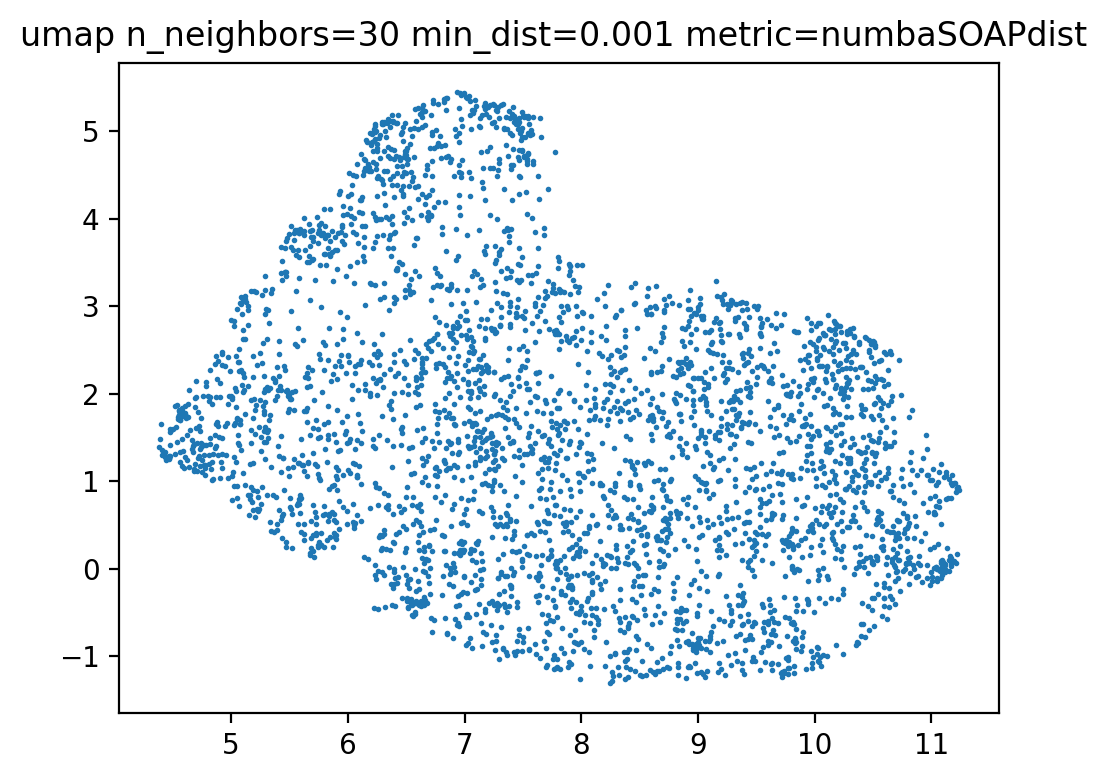

In [18]:
removeAXE = False

fig, ax = plotTools.get_axes(1)

if XsubEmb.shape[1] > 2:
    ax.scatter(XsubEmb[:,0], XsubEmb[:,1], c=XsubEmb[:,2], s=10)
elif XsubEmb.shape[1] == 2:
    ax.scatter(*XsubEmb.T, s=1)

title_str = ''
for par,val in emb_dict.items():
    if isinstance(val, str):
        title_str += par+'='+val+' '
    elif isinstance(val, int) or isinstance(val, float):
        title_str += par+'='+str(val)+' '
    else:
        title_str += par+'='+val.__name__+' '
    
ax.set_title(f'{method} {title_str}')
if removeAXE:
    plotTools.remove_frame(ax)

fig.tight_layout()
# fig.savefig(f"{prod_dir}{method}{Xemb.shape[1]}_reduction_{sysInfoName}{sysSpecInfo}", 
#             transparent=True)

### clustering

In [31]:
def make_colors(clust, mode='tab10'):
    if np.min(clust) == -1:
        N = np.unique(clust).shape[0] - 1
        colors = [(0,0,0)] + sns.color_palette(mode, N)
    else:
        N = np.unique(clust).shape[0]
        colors = sns.color_palette(mode, N)
    return colors

In [32]:
import hdbscan

In [33]:
# clustDict = dict(
#     min_cluster_size=15,
#     min_samples=15,
#     cluster_selection_epsilon=0.2,
#     alpha=1.0
# )

In [46]:
clustDict = {'min_cluster_size': 50, 
             'min_samples': 15, 
             'cluster_selection_epsilon': 0.2, 
             'alpha': 1.0}

In [47]:
clustModel = hdbscan.HDBSCAN(**clustDict)
clustModel.fit(XsubEmb)
labels = clustModel.labels_
colors = make_colors(labels)

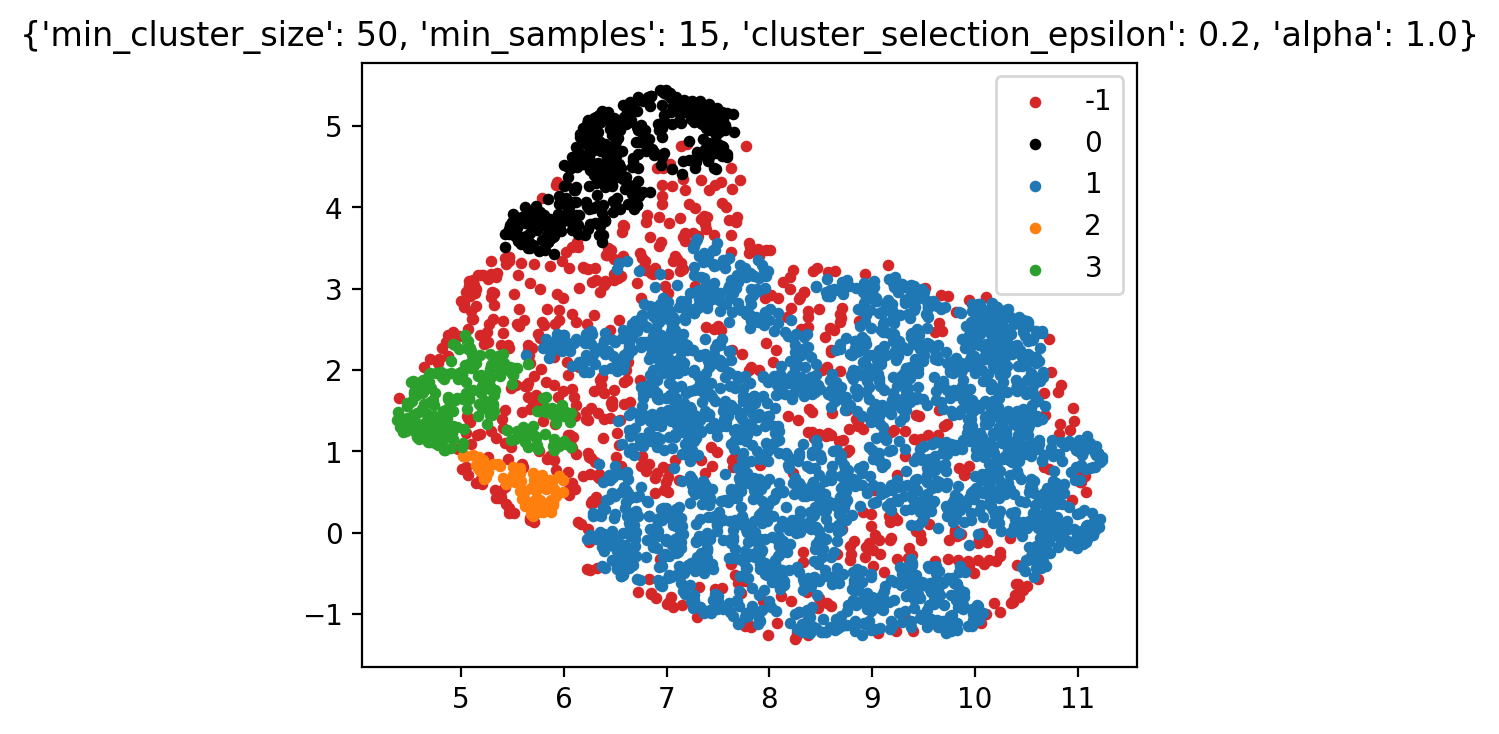

In [48]:
fig, ax = plotTools.get_axes(1)
for colo in np.unique(labels):
    mask = labels == colo
    ax.scatter(*XsubEmb[mask].T, 
               color=colors[colo], 
               s=10, label=colo)
ax.set_title(f"{clustDict}")
# plotTools.remove_frame(ax)
ax.legend()